# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from kneed import KneeLocator

DATA_DIR = 'data'

## Task 0: Research Question

**Research question:**
*Your chosen research question goes here*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

### A) Student Activity (Inputs):

##### 1) Student Activity Cleaning:

**Approach:**

We will begin by loading the `activity` dataset and processing it as follows:

- Cast columns to appropriate data types (e.g., convert to datetime formats)  
- Remove entries with missing `activity_completed` values or inconsistent timestamps (e.g., when completion occurs before the activity starts)  
- Remove entries where the activity duration exceeds 24 hours, as these likely indicate inactivity (e.g., students leaving the activity open)

In [2]:
# Load the data
activity = pd.read_csv(f'{DATA_DIR}/activity.csv')
activity_sizes = {'Original': len(activity)}

# Cast timestamps to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

# Remove entries where the activity_completed was before the activity_started
activity = activity[activity['activity_completed'] > activity['activity_started']]
activity_sizes['After removing missing or inconcistent completion'] = len(activity)

# Create a column with the duration of the activity
activity['activity_duration'] = activity['activity_completed'] - activity['activity_started']
activity['activity_duration_minutes'] = activity['activity_duration'].dt.total_seconds() / 60

# Remove entries where the activity_completed is more than 24 hours after the activity_started
activity = activity[activity['activity_duration_minutes'] <= 24 * 60]
activity_sizes['After removing duration > 24h'] = len(activity)

In addition to removing entries where the activity duration exceeds 24 hours, we will also eliminate remaining outliers using the IQR method, as it is still unlikely that a student would spend several hours on a single activity. The IQR method provides a statistically grounded threshold for identifying such outliers, removing the need to define a manual cutoff.

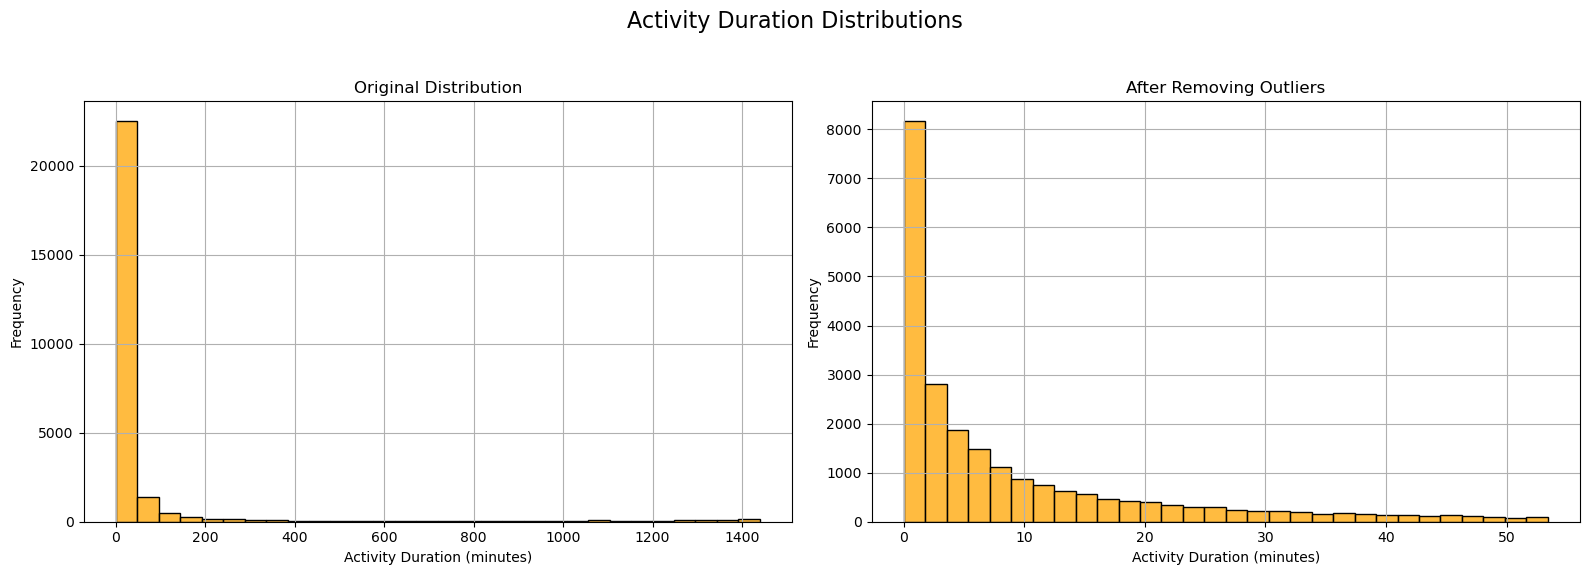

In [3]:
# Compute IQR bounds for filtering
Q1 = activity['activity_duration_minutes'].quantile(0.25)
Q3 = activity['activity_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Activity Duration Distributions", fontsize=16)

# Before filtering
sns.histplot(activity['activity_duration_minutes'], bins=30, color='orange', ax=axes[0])
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Activity Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].grid()

# Filter outliers
activity = activity[
    (activity['activity_duration_minutes'] >= lower_bound) &
    (activity['activity_duration_minutes'] <= upper_bound)
]
activity_sizes['After removing remaining outliers'] = len(activity)

# After filtering
sns.histplot(activity['activity_duration_minutes'], bins=30, color='orange', ax=axes[1])
axes[1].set_title('After Removing Outliers')
axes[1].set_xlabel('Activity Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
# Dataset evolution
print("Data set sizes at each stage:")
for stage, size in activity_sizes.items():
    print(f"- {stage}: {size} entries ({size / activity_sizes['Original'] * 100:.2f}%)")


Data set sizes at each stage:
- Original: 72897 entries (100.00%)
- After removing missing or inconcistent completion: 38881 entries (53.34%)
- After removing duration > 24h: 26217 entries (35.96%)
- After removing remaining outliers: 22754 entries (31.21%)


**Observation:**

We observe that before applying the IQR method to filter out remaining outliers, the distribution of activity duration is right-skewed, with numerous extreme values reaching up to 1,400 mins (≈ 23 hours).

After removing these outliers, the distribution remains right-skewed—likely resembling an exponential distribution, with durations ranging from 0 minutes to 1 hour.

Empirically, we found that the IQR method performs more effectively when applied after first removing entries with durations exceeding 24 hours, rather than relying on it alone.

After applying all filters, we are left with 22,754 entries—about 31% of the original dataset. The most significant reduction occurs when removing entries with missing or inconsistent completion times, which alone reduces the dataset from 100% to 53%.  

One possible solution to retain more data would be to predict the missing completion times. However, this could compromise the reliability of the analysis by introducing less representative user behavior. Therefore, we chose to leave this as a potential direction for future work, if deemed necessary.

##### 2) Student Feature Creation:

In [5]:
user_daily_activity = activity.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

display(user_daily_activity.head())
print(f'Number of unique user entries: {user_daily_activity.user_id.nunique()}')
print(f'Number of unique (user, day) entries: {user_daily_activity.shape[0]}')


,user_id,active_day,gap_days
36137,1,2024-11-02,NaN
45192,1,2024-11-25,23.0
47334,1,2024-11-29,4.0
49725,1,2024-12-06,7.0
49736,1,2024-12-07,1.0


Number of unique user entries: 843
Number of unique (user, day) entries: 6273


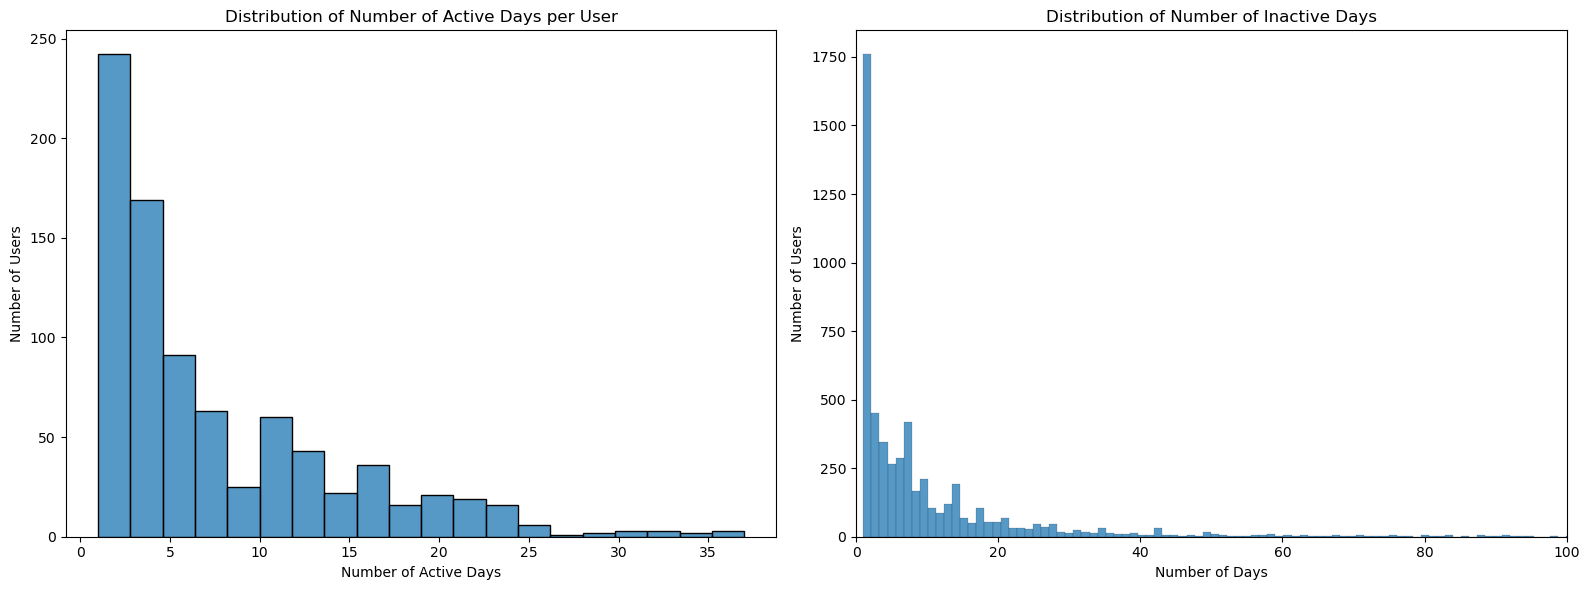

In [6]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of number of active days per user
sns.histplot(user_daily_activity['user_id'].value_counts(), bins=20, ax=axes[0])
axes[0].set_title('Distribution of Number of Active Days per User')
axes[0].set_xlabel('Number of Active Days')
axes[0].set_ylabel('Number of Users')

# Histogram of gaps between active days
sns.histplot(user_daily_activity['gap_days'], ax=axes[1])
axes[1].set_title('Distribution of Number of Inactive Days')
axes[1].set_xlabel('Number of Days')
axes[1].set_ylabel('Number of Users')
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()

user profile

In [7]:
# Compute the median of gap_days per user
user_profile_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
user_profile_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)

# Add the number of active days of that user (count)
user_profile_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

# Add the median activity duration of that user (activity_completed - activity_started) only when activity_completed is not missing
user_profile_activity['median_activity_duration'] = activity.groupby('user_id').apply(
    lambda x: (x['activity_completed'] - x['activity_started']).median() if not x['activity_completed'].isnull().all() else np.nan
).values
# Add the number of activities of that user (count)
user_profile_activity['activities_count'] = activity.groupby('user_id')['activity_id'].count().values
# Add the number of unique activity types of that user
user_profile_activity['activity_types_count'] = activity.groupby('user_id')['activity_type'].nunique().values

# Convert timedelta to minutes
user_profile_activity['median_activity_duration_minutes'] = user_profile_activity['median_activity_duration'].dt.total_seconds() / 60

/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_51317/1384183799.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_profile_activity['median_activity_duration'] = activity.groupby('user_id').apply(


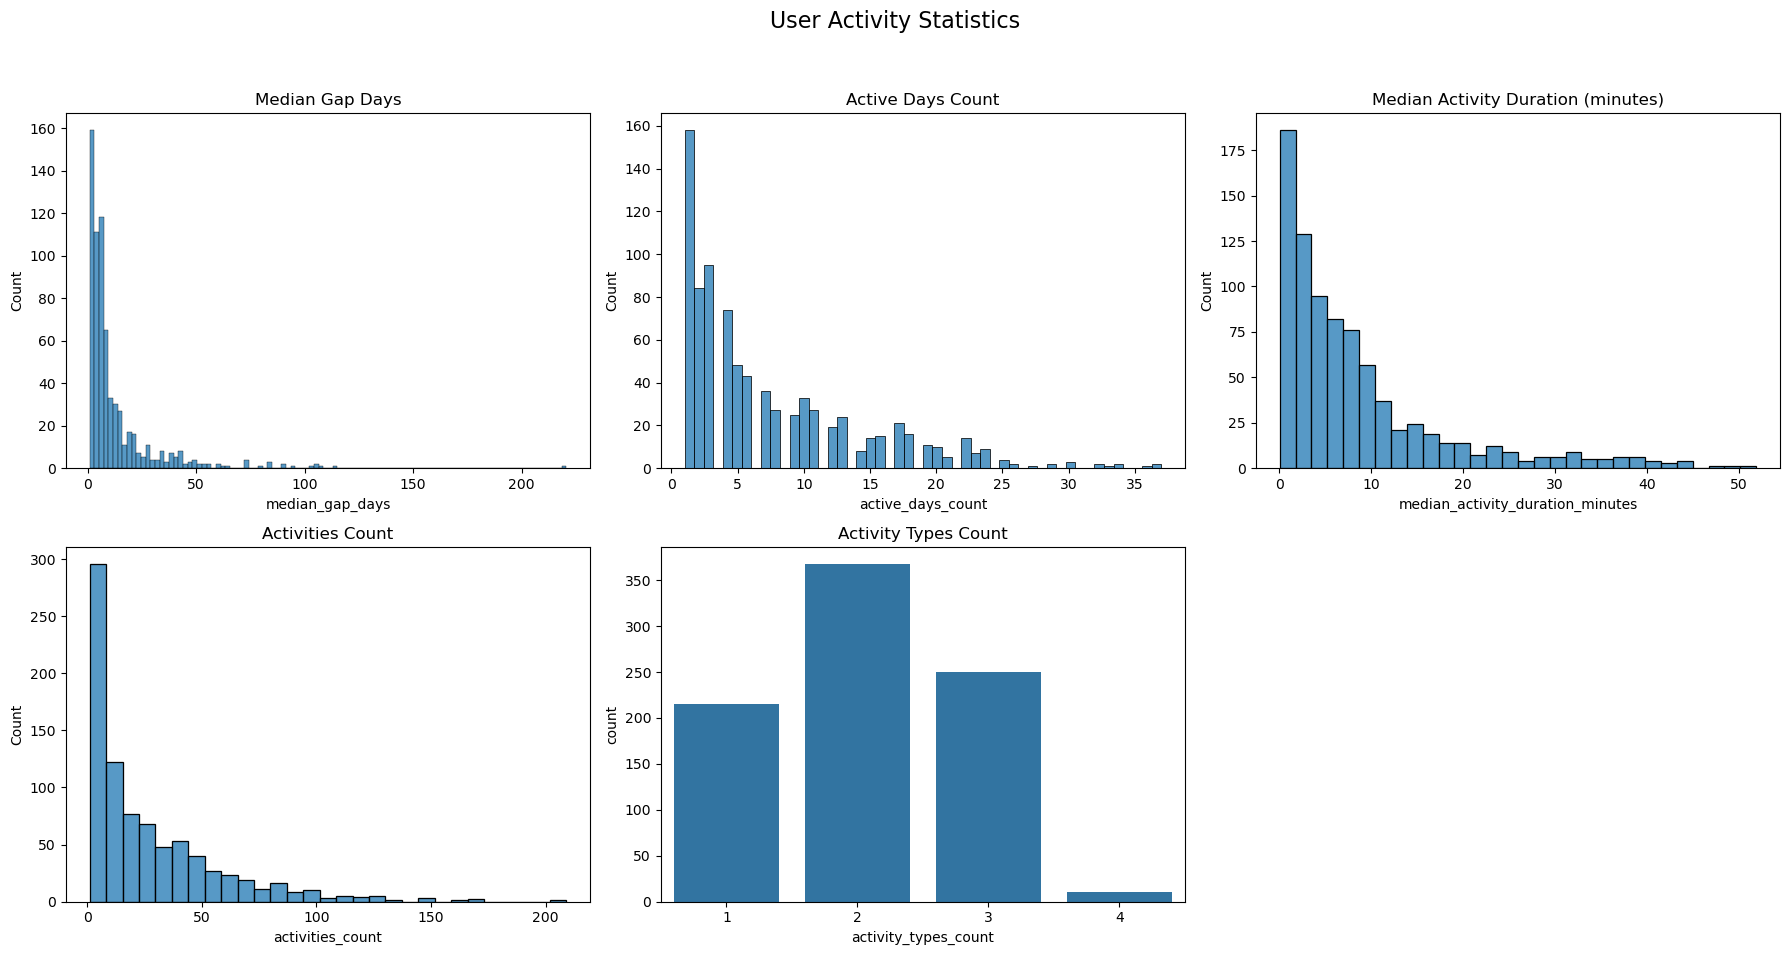

In [8]:
# Plot each column in a suitable seaborn chart using a single figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("User Activity Statistics", fontsize=16)

# Histogram for median_gap_days
sns.histplot(user_profile_activity['median_gap_days'], ax=axes[0, 0])
axes[0, 0].set_title('Median Gap Days')

# Histogram for active_days_count
sns.histplot(user_profile_activity['active_days_count'], bins=50, ax=axes[0, 1])
axes[0, 1].set_title('Active Days Count')

# Boxplot for median_activity_duration
sns.histplot(user_profile_activity['median_activity_duration_minutes'], ax=axes[0, 2], bins=30)
axes[0, 2].set_title('Median Activity Duration (minutes)')

# Histogram for activities_count
sns.histplot(user_profile_activity['activities_count'], ax=axes[1, 0])
axes[1, 0].set_title('Activities Count')

# Countplot for activity_types_count
sns.countplot(x=user_profile_activity['activity_types_count'], ax=axes[1, 1])
axes[1, 1].set_title('Activity Types Count')

# Hide the last unused subplot
axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
print("- Activity per user per day:")
display(user_daily_activity.head())
print("Shape:", user_daily_activity.shape)

print("\n\n- User profile:")
display(user_profile_activity.head())
print("Shape:", user_profile_activity.shape)

- Activity per user per day:


,user_id,active_day,gap_days
36137,1,2024-11-02,NaN
45192,1,2024-11-25,23.0
47334,1,2024-11-29,4.0
49725,1,2024-12-06,7.0
49736,1,2024-12-07,1.0


Shape: (6273, 3)


- User profile:


,user_id,median_gap_days,active_days_count,median_activity_duration,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,0 days 00:04:43,19,2,4.716667
1,4,7.5,7,0 days 00:02:16,31,1,2.266667
2,6,7.0,9,0 days 00:07:39.500000,30,2,7.658333
3,7,4.0,16,0 days 00:13:35,30,2,13.583333
4,9,12.0,8,0 days 00:06:28,26,2,6.466667


Shape: (843, 7)


### B) Student Scores (Outputs):

**Approach:**

We will begin by loading the `all_scores` dataset and processing it as follows:

- Cast columns to appropriate data types (e.g., convert to datetime formats)
- Aggregate the scores for each student by computing the median of their scores

In [10]:
# Load the data
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

# Cast timestamps to datetime
all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')

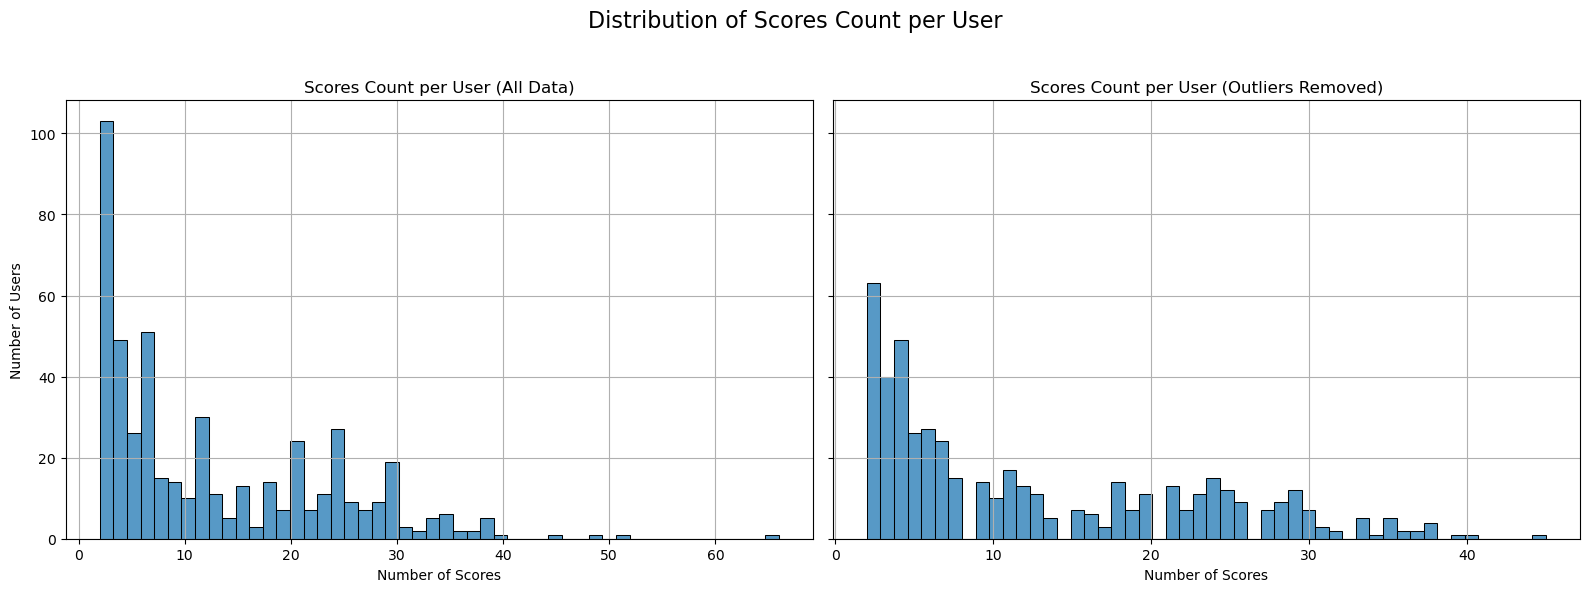

Number of users before outlier removal: 494
Number of users after outlier removal: 491 (99.39%)


In [11]:
# Compute median and count of scores per user
students_median_score = all_scores.groupby('user_id')['percentage'].median().reset_index()
students_median_score.rename(columns={'percentage': 'median_score'}, inplace=True)
students_median_score['scores_count'] = all_scores.groupby('user_id')['percentage'].count().values

# Remove users with less than 1 score
students_median_score = students_median_score[students_median_score['scores_count'] > 1]

# Plot 1: Original distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.histplot(students_median_score['scores_count'], bins=50, ax=axes[0])
axes[0].set_title('Scores Count per User (All Data)')
axes[0].set_xlabel('Number of Scores')
axes[0].set_ylabel('Number of Users')
axes[0].grid()

# IQR Outlier Removal (in-place on df)
Q1 = students_median_score['scores_count'].quantile(0.25)
Q3 = students_median_score['scores_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter in-place
length_before = len(students_median_score)
students_median_score = students_median_score[(students_median_score['scores_count'] >= lower_bound) & (students_median_score['scores_count'] <= upper_bound)]
length_after = len(students_median_score)

# Plot 2: After outlier removal
sns.histplot(students_median_score['scores_count'], bins=50, ax=axes[1])
axes[1].set_title('Scores Count per User (Outliers Removed)')
axes[1].set_xlabel('Number of Scores')
axes[1].grid()

plt.suptitle('Distribution of Scores Count per User', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"Number of users before outlier removal: {length_before}")
print(f"Number of users after outlier removal: {length_after} ({length_after / length_before * 100:.2f}%)")

Once again, we removed outlier students—those with very few or very many entries—using the IQR method. This helps eliminate bias from users who participated only once, as well as those who were unusually active and not representative of the majority. While filtering out users with too few entries was necessary, removing the highly active users was optional. In both cases, the distributions are right-skewed.

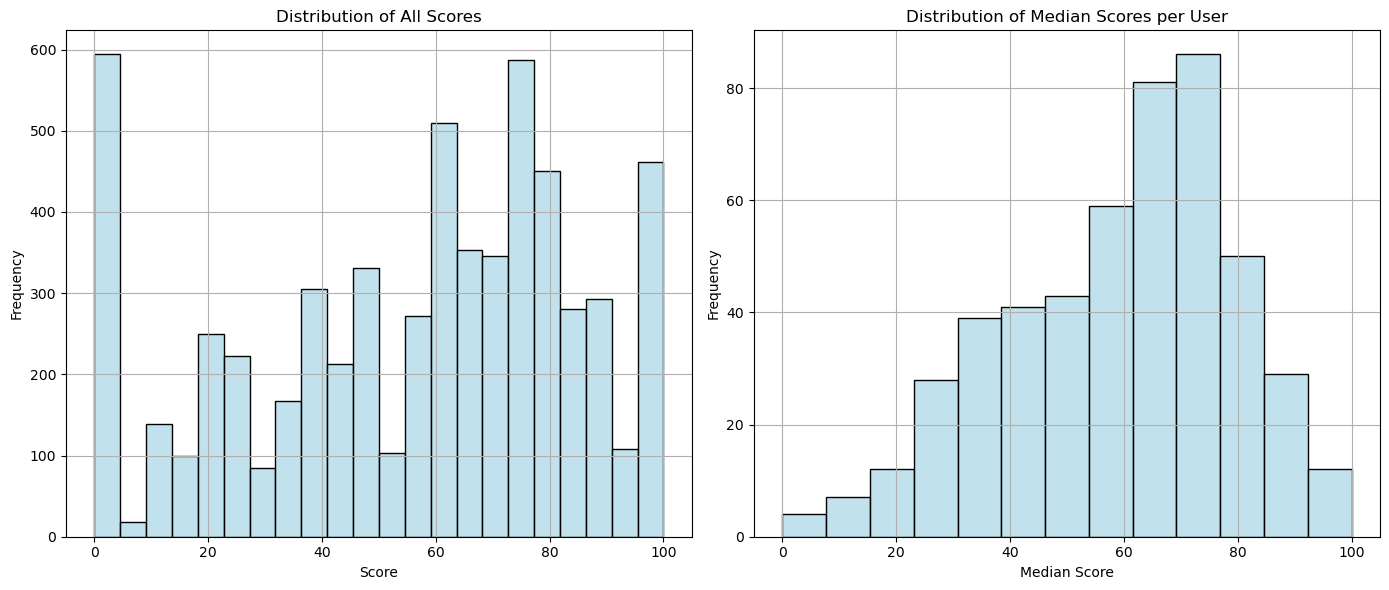

In [12]:
# Apply the outlier removal to the all_scores dataframe
all_scores = all_scores[all_scores['user_id'].isin(students_median_score['user_id'])]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Distribution of all individual scores
sns.histplot(all_scores['percentage'], color='lightblue', ax=axes[0])
axes[0].set_title('Distribution of All Scores')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Right: Distribution of median scores per user
sns.histplot(students_median_score['median_score'], color='lightblue', ax=axes[1])
axes[1].set_title('Distribution of Median Scores per User')
axes[1].set_xlabel('Median Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Observation:**

The chart on the left shows the distribution of all individual scores. We observe a noisy Gaussian-like distribution with two unusual peaks at 0 and 100. One possible explanation is that the scores are expressed as percentages, and exercises graded out of 1 point can result only in 0% or 100%.

On the right, we see the distribution of each student's median score, which follows a normal distribution centered around 75%. Notably, the sharp peaks at 0 and 100 disappear after aggregating by student. This is likely due to the use of the median, which is less sensitive to outliers than the mean.

From this point onward, we will consider only the median score per user (i.e., the overall user grade), as shown in the chart on the right.

In [13]:
# Create a final dataframe with user activity and scores
students = user_profile_activity.merge(
    students_median_score,
    how='inner',
    left_on='user_id',
    right_on='user_id'
)

# Print number of users
print(f"Number of users in user_profile_activity: {user_profile_activity['user_id'].nunique()}")
print(f"Number of users in students_median_score: {students_median_score['user_id'].nunique()}")
print(f"Number of users after merging: {students['user_id'].nunique()}")

Number of users in user_profile_activity: 843
Number of users in students_median_score: 491
Number of users after merging: 472


We end up with a final `students` dataset containing 545 students, which closely matches the size of the scores dataset (95% overlap).

## Task 2: Model Building

Train a model for your research question. 

### A) Student Clustering (Profiles):

We will create clusters of students to better understand the different learner profiles. To achieve this, we will use an unsupervised learning approach with K-Means clustering.

The key hyperparameters we will determine are:

- **Features used for clustering:** Determined through correlation analysis and machine learning coefficient interpretation.
- **Number of clusters (K):** Determined using the Elbow method  

##### 1) Hyperparameter Tuning of Clustering Features:

**Approach:**

- **Corralation Analysis:** As observed in Task A, the scores follow a Gaussian distribution. However, the input features are highly right-skewed and appear to follow an exponential distribution. Therefore, we will use Spearman correlation instead of Pearson, as the latter is only appropriate for normally distributed data.

- **Machine Learning Coefficient Interpretation:** We will use a linear regression model to interpret the coefficients and understand which features are most strongly associated with the output. Since the goal is interpretation rather than prediction, we will train the model on the full dataset without splitting it into training and evaluation sets. However, to ensure robustness, we will perform cross-validation and average the coefficient weights across folds.

In [14]:
# Define the candidate features for clustering
candidate_features = [
    'median_gap_days',
    'active_days_count',
    'activities_count',
    'activity_types_count',
    'median_activity_duration_minutes'
]

# Define the target variable
target = 'median_score'

# Drop entries with missing values in the candidate features and target (necessary for models)
students_no_nan = students.dropna(subset=candidate_features + [target], inplace=False)

# Print number of entries after dropping NaN values, and percentage of entries kept
print(f"Number of entries after dropping NaN values: {students_no_nan.shape[0]}")
print(f"Percentage of entries kept: {students_no_nan.shape[0] / students.shape[0] * 100:.2f}%")

Number of entries after dropping NaN values: 451
Percentage of entries kept: 95.55%


In [15]:
# Approach 1: Spearman correlation
correlations = []
for feature in candidate_features:
    corr = students_no_nan[[feature, target]].corr(method='spearman').iloc[0, 1]
    correlations.append(corr)

In [16]:
# Approach 2: Linear regression coefficients
X = students_no_nan[candidate_features]
y = students_no_nan[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_coefs = []

# Cross-validated linear regression
for train_index, test_index in kf.split(X_scaled):
    X_train, y_train = X_scaled[train_index], y.iloc[train_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    all_coefs.append(model.coef_)

# Average coefficients across folds
weights = np.mean(all_coefs, axis=0)

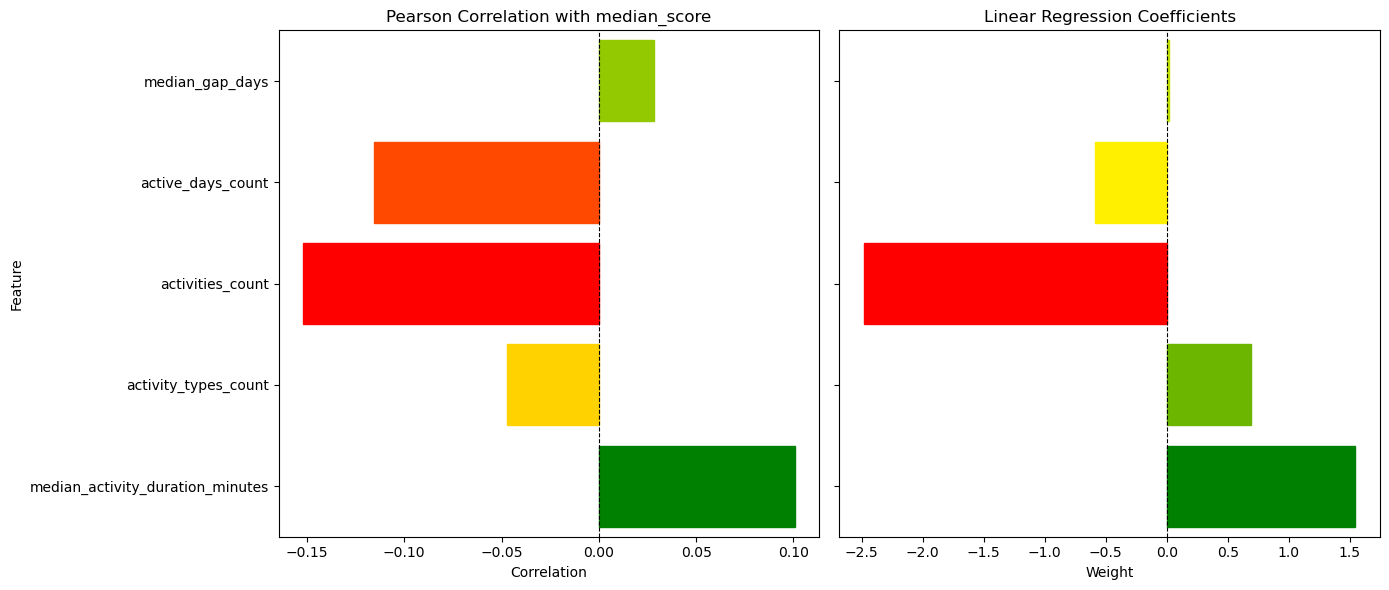

In [17]:
# Combine into DataFrame
combined_df = pd.DataFrame({
    'Feature': candidate_features,
    'Pearson Correlation': correlations,
    'Linear Regression Weight': weights
})

# Custom red-to-green gradient
custom_cmap = LinearSegmentedColormap.from_list("custom_red_green", ["red", "yellow", "green"])
norm_corr = Normalize(vmin=min(correlations), vmax=max(correlations))
norm_weight = Normalize(vmin=min(weights), vmax=max(weights))

# Handle colors
corr_colors = [custom_cmap(norm_corr(val)) for val in correlations]
weight_colors = [custom_cmap(norm_weight(val)) for val in weights]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Correlation barplot
bars_corr = sns.barplot(x='Pearson Correlation', y='Feature', data=combined_df, ax=axes[0], color='gray')
for bar, color in zip(bars_corr.patches, corr_colors):
    bar.set_color(color)
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title('Pearson Correlation with median_score')
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('Feature')

# Linear regression barplot
bars_weight = sns.barplot(x='Linear Regression Weight', y='Feature', data=combined_df, ax=axes[1], color='gray')
for bar, color in zip(bars_weight.patches, weight_colors):
    bar.set_color(color)
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title('Linear Regression Coefficients')
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


**Observation:**

TODO: 

##### 2) Hyperparameter Tuning of Number of Clusters (K):

**Approach:**

We will use K-Means clustering and determine the optimal number of clusters using the Elbow method. The Euclidean distance metric will be used, as it is well-suited for our data, where all features are numerical.

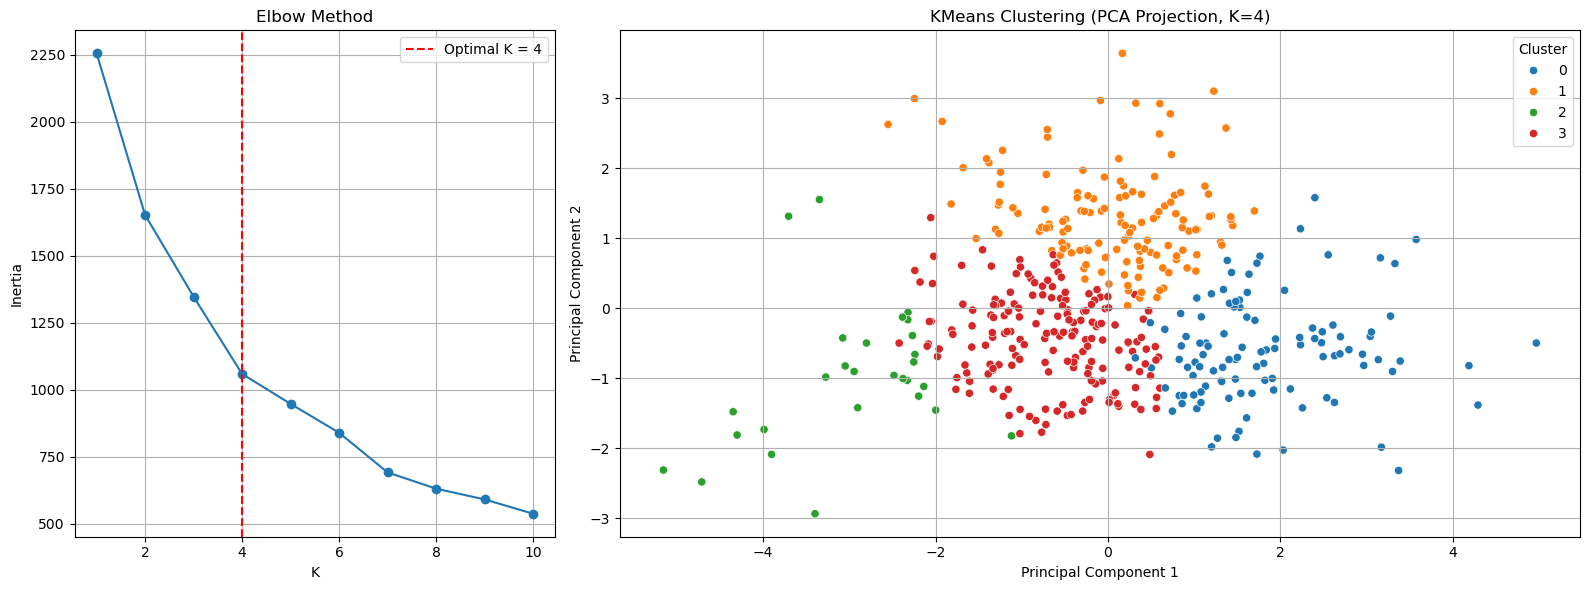

In [18]:
# Use all features for clustering
columns_used = candidate_features
X = students_no_nan[columns_used]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Elbow method to find optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Select optimal K
knee = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee.knee

# Apply KMeans with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
students_no_nan = students_no_nan.copy()
students_no_nan['cluster'] = kmeans.fit_predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})

# Plot Elbow chart
axes[0].plot(K_range, inertia, marker='o')
axes[0].axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].legend()
axes[0].grid(True)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to the DataFrame
students_projection_pca = students_no_nan.copy()
students_projection_pca['PCA1'] = X_pca[:, 0]
students_projection_pca['PCA2'] = X_pca[:, 1]

# Plot Cluster scatterplot using PCA components
sns.scatterplot(
    data=students_projection_pca,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='tab10',
    ax=axes[1]
)
axes[1].set_title(f"KMeans Clustering (PCA Projection, K={optimal_k})")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(title='Cluster')
axes[1].grid(True)

plt.tight_layout()
plt.show()


**Observation:**

As shown in the chart on the left, after selecting the clustering features, we used the Elbow method with K-Means to determine that the optimal number of clusters is **4**.

The chart on the right presents a PCA projection of the data onto two dimensions, with the resulting clusters visualized. Note that the clustering was performed on the original feature space, not on the 2D projection, which is used solely for visualization purposes.

TODO: Interpret the right chart?

##### 3) Score Comparison Across Clusters and Interpretation:

Now that we have our clusters, we will compare student scores across them by analyzing the median grade within each cluster. Specifically, we will compute the median of each feature across all students in each cluster. This aggregation approach helps reduce the impact of outliers and provides a more robust comparison.

In [19]:
# Median feature values per cluster
cluster_values = students_no_nan.groupby('cluster')[columns_used].median().T
cluster_values.columns = [f'Cluster {c}' for c in cluster_values.columns]

# Add median score and user count
cluster_score = students_no_nan.groupby('cluster')['median_score'].median().reset_index()
cluster_score['users_count'] = students_no_nan.groupby('cluster')['user_id'].nunique().values
cluster_score = cluster_score.set_index('cluster').T
cluster_score.columns = [f'Cluster {c}' for c in cluster_score.columns]

# Combine values + scores
cluster_values_df = pd.concat([cluster_values, cluster_score], axis=0)

# Display numeric summary
display(cluster_values_df)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
median_gap_days,4.000000,6.000000,41.500000,7.000000
active_days_count,17.000000,14.000000,3.000000,6.000000
activities_count,79.500000,36.000000,9.500000,21.500000
activity_types_count,3.000000,2.000000,2.000000,2.000000
median_activity_duration_minutes,2.729167,11.016667,3.825000,3.679167
median_score,57.320000,62.500000,72.382353,63.432206
users_count,108.000000,135.000000,28.000000,180.000000


**Interpretation and Visualization Approach:**

The features will be interpreted using simple, color-coded labels for easier readability. Users will be divided into three equally sized groups (low, medium, high) based on how their feature values compare to others. For features with a clear positive or negative impact, text colors will reflect the interpretation (e.g., green for favorable values, red for unfavorable ones), while neutral features will use plain labels.  

Additionally, clusters (profiles) will be ordered in decreasing order of their median score to facilitate interpretation.

In [22]:
feature_display_names = {
    'median_gap_days': 'Usage Frequency',
    'active_days_count': 'Total Active Days',
    'activities_count': 'Total Activities',
    'activity_types_count': 'Activity Types',
    'median_activity_duration_minutes': 'Activity Duration',
    'median_score': 'Median Score',
    'users_count': 'Number of Students'
}

def create_interpretation_df(use_auto_colors, interpretation_labels, feature_to_corr=None, custom_cmap=None):
    # Rename cluster columns to "Profile {n+1}"
    profile_values = cluster_values.copy()
    profile_values.columns = [f'Profile {int(c.split()[-1]) + 1}' for c in profile_values.columns]
    
    interpretation_df = pd.DataFrame(index=profile_values.index, columns=profile_values.columns, dtype=object)

    for feature in interpretation_df.index:
        data = students_no_nan[feature]
        values = profile_values.loc[feature]

        if feature == 'median_gap_days':
            data = -data
            values = -values

        _, bins = pd.qcut(data, q=3, retbins=True, duplicates='drop')
        labels = interpretation_labels.get(feature, ['Low', 'Medium', 'High'])[:len(bins) - 1]

        for profile in profile_values.columns:
            bin_index = pd.cut([values[profile]], bins=bins, labels=range(len(labels)), include_lowest=True)[0]
            label_text = labels[int(bin_index)]

            if use_auto_colors:
                corr = feature_to_corr.get(feature, 0)
                if corr >= 0:
                    color = custom_cmap(int(bin_index) / 2)
                else:
                    reversed_bin = 2 - int(bin_index)
                    color = custom_cmap(reversed_bin / 2)
            else:
                color_map = {'Red': 'red', 'Yellow': 'orange', 'Green': 'green'}
                label_text, label_color = interpretation_labels[feature][int(bin_index)]
                color = color_map[label_color]

            interpretation_df.loc[feature, profile] = (label_text, color)

    interpretation_df.loc['median_score'] = [(f"{val:.1f}", None) for val in median_score_row]
    interpretation_df.loc['users_count'] = [(f"{int(val)}", None) for val in users_count_row]
    interpretation_df.index = interpretation_df.index.map(lambda f: feature_display_names.get(f, f))

    return interpretation_df

def plot_interpretation_table(ax, interpretation_df, title):
    sorted_profiles = median_score_row[interpretation_df.columns].sort_values(ascending=False).index.tolist()
    ordered_df = interpretation_df[sorted_profiles]
    student_counts = interpretation_df.loc["Number of Students"]
    student_counts = student_counts[sorted_profiles]
    col_headers = [f"Profile {i+1}\n({int(float(student_counts[col][0]))} students)" for i, col in enumerate(sorted_profiles)]

    display_df = ordered_df.drop(index="Number of Students")
    color_df = ordered_df.drop(index="Number of Students")
    display_df = display_df.map(lambda x: x[0] if isinstance(x, tuple) else x)

    ax.axis('off')
    table = ax.table(
        cellText=display_df.values,
        rowLabels=display_df.index,
        colLabels=col_headers,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.8)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_height(0.18)
            continue
        row_label = display_df.index[row - 1]
        if row_label == "Median Score":
            cell.get_text().set_fontweight('bold')
            cell.get_text().set_color('black')
            continue
        value = color_df.iloc[row - 1, col]
        if isinstance(value, tuple) and value[1] is not None:
            cell.get_text().set_color(value[1])

    median_index = display_df.index.get_loc("Median Score") + 1
    row_label_cell = table[(median_index, -1)]
    row_label_cell.get_text().set_fontweight('bold')
    row_label_cell.get_text().set_color('black')

    for row in range(1, len(display_df.index) + 1):
        label_cell = table[(row, -1)]
        label_cell.get_text().set_color('black')

    ax.set_title(title)

# Setup
custom_cmap = LinearSegmentedColormap.from_list("custom_red_orange_green", ["red", "orange", "green"])
feature_to_corr = dict(zip(candidate_features, correlations))

# Manual interpretation labels
manual_labels = {
    'median_gap_days': [('Rarely', 'Red'), ('Occasionally', 'Yellow'), ('Frequently', 'Green')],
    'active_days_count': [('Low Activity', 'Red'), ('Moderate Activity', 'Yellow'), ('High Activity', 'Green')],
    'activities_count': [('Few Activities', 'Red'), ('Some Activities', 'Yellow'), ('Many Activities', 'Green')],
    'median_activity_duration_minutes': [('Short Duration', 'Red'), ('Moderate Duration', 'Yellow'), ('Long Duration', 'Green')],
    'activity_types_count': [('Narrow Focus', 'Red'), ('Moderate Variety', 'Yellow'), ('Diverse Activity', 'Green')],
}

auto_labels = {
    'median_gap_days': ['Rarely', 'Occasionally', 'Frequently'],
    'active_days_count': ['Low Activity', 'Moderate Activity', 'High Activity'],
    'activities_count': ['Few Activities', 'Some Activities', 'Many Activities'],
    'median_activity_duration_minutes': ['Short Duration', 'Moderate Duration', 'Long Duration'],
    'activity_types_count': ['Narrow Focus', 'Moderate Variety', 'Diverse Activity'],
}

# Prepare shared cluster_score rows
adjusted_cluster_score = cluster_score.copy()
adjusted_cluster_score.columns = [f'Profile {int(c.split()[-1]) + 1}' for c in adjusted_cluster_score.columns]
median_score_row = adjusted_cluster_score.loc['median_score']
users_count_row = adjusted_cluster_score.loc['users_count']

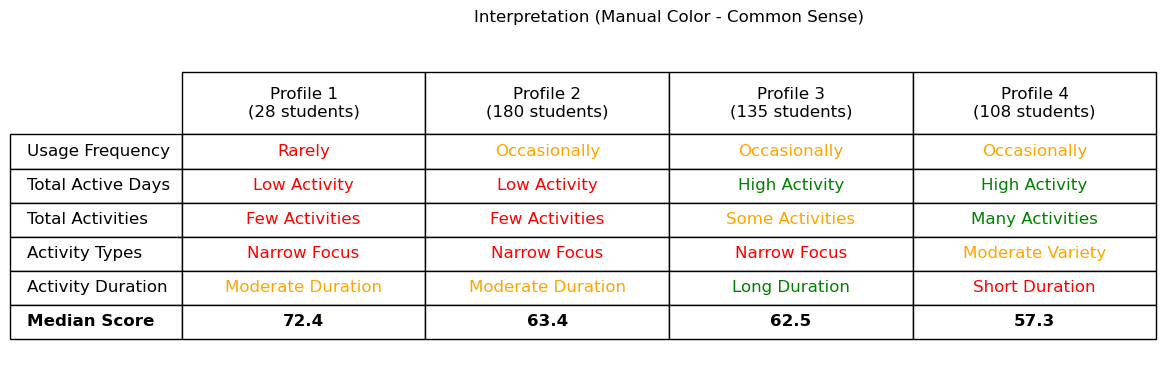

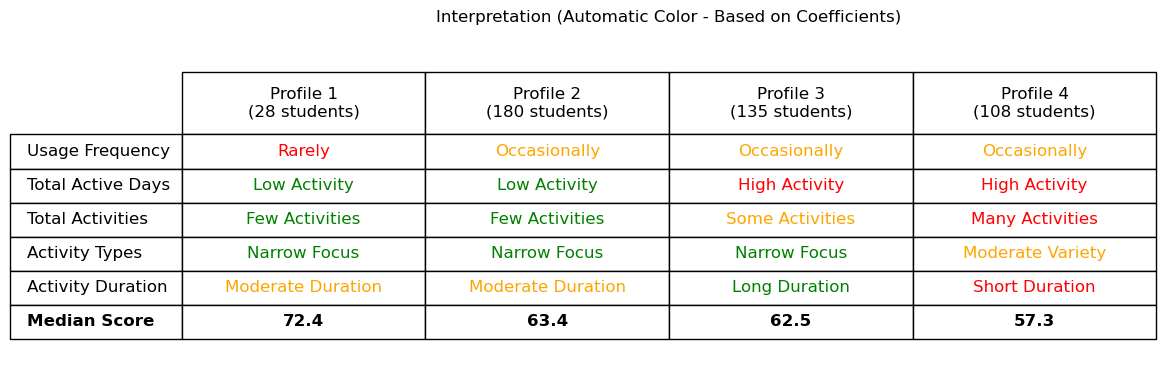

In [23]:
# Create both interpretation DataFrames
manual_df = create_interpretation_df(False, manual_labels)
auto_df = create_interpretation_df(True, auto_labels, feature_to_corr, custom_cmap)

# Plot first table in its own figure
fig1, ax1 = plt.subplots(figsize=(12, 4))
plot_interpretation_table(ax1, manual_df, "Interpretation (Manual Color - Common Sense)")
plt.tight_layout()
plt.show()

# Plot second table in a separate figure
fig2, ax2 = plt.subplots(figsize=(12, 4))
plot_interpretation_table(ax2, auto_df, "Interpretation (Automatic Color - Based on Coefficients)")
plt.tight_layout()
plt.show()

**Observation:**

TODO: Interprete the clusters and explain why they are not perfect. Use also the feature coefficient done before to explain ? Demander au TA d'abord s'il faut garder les couleurs logiques (celles qui donnent actuellement ces résultats), ou bien celle des coefficient (qui seront plus cohérente).

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [ ]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*